In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#pip install qiskit

In [3]:
#pip install pylatexenc

In [4]:
#pip install qiskit-aer

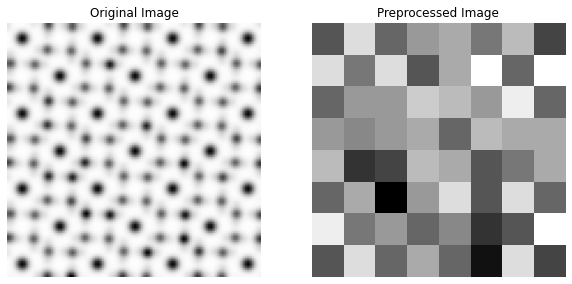

In [5]:
def preprocess_image(image_path, size=(8, 8)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

# Load and display the original image
image_path = 'Images/IrMnO2/resized_bf_image_Ir3pc_1e6dpa.png'  # Replace with your image path
original_img = Image.open(image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Preprocess the image
img_array = preprocess_image(image_path)

plt.subplot(1, 2, 2)
plt.imshow(img_array, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

In [7]:
img_array.shape

(8, 8)

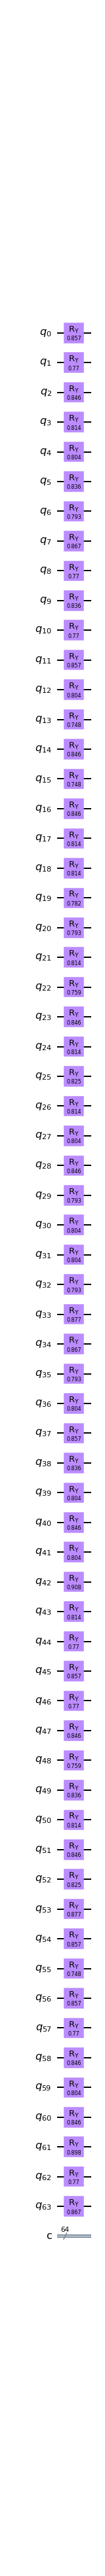

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = 64 #int(np.ceil(np.log2(size * size)))
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

# Encode the image into a quantum circuit
qc_image = encode_image(img_array)

# Draw the circuit for image encoding
circuit_image_encoding = circuit_drawer(qc_image, output='mpl', plot_barriers=False, justify='left')
circuit_image_encoding.savefig('quantum_image_encoding.png')

# Display the saved image
from IPython.display import Image
Image(filename='quantum_image_encoding.png')

In [2]:
#Processing
from qiskit.circuit.library import MCXGate

In [11]:
# Attempting for the bright field with 1e6 dpa and 3pc Ir

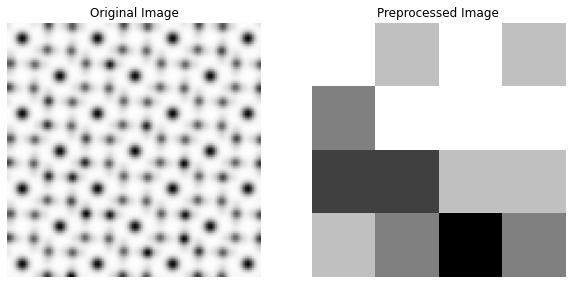

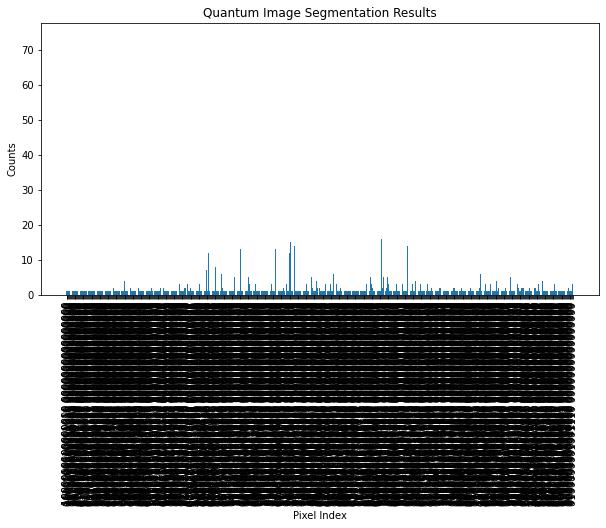

In [10]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

def preprocess_image(image_path, size=(4, 4)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = size * size  # We need one qubit per pixel
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

def create_oracle(img_array, threshold=0.5):
    size = img_array.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    
    # Apply X gates for pixels below the threshold
    for i, pixel in enumerate(img_array.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))

def interpret_results(counts, size):
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image

def main(image_path):
    # Load and display the original image
    original_img = Image.open(image_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Preprocess the image
    img_array = preprocess_image(image_path)

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()

    # Encode the image into a quantum circuit
    qc_image = encode_image(img_array)

    # Create the oracle for the given image
    oracle = create_oracle(img_array)

    # Apply Grover's search
    apply_grovers_search(qc_image, oracle)

    # Measure the results
    qc_image.measure_all()

    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc_image, simulator)
    qobj = assemble(compiled_circuit)
    result = simulator.run(qobj).result()
    counts = result.get_counts()

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title("Quantum Image Segmentation Results")
    plt.xlabel("Pixel Index")
    plt.ylabel("Counts")
    plt.xticks(rotation=90)
    plt.show()

    # Interpret the results
def interpret_results(counts, size):
    print("Counts:", counts)  # Debug: Print counts to see their format
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ', '')  # Remove any spaces in the bitstring
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image


# Run the main function with the path to your image
main('Images/IrMnO2/resized_bf_image_Ir3pc_1e6dpa.png')  # Replace with your image path

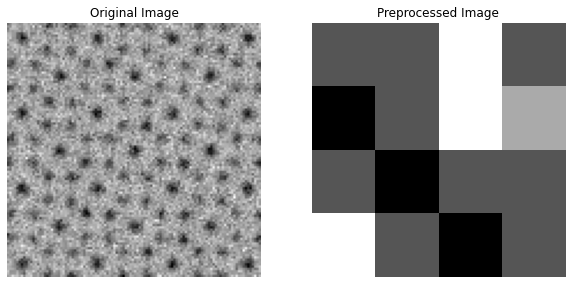

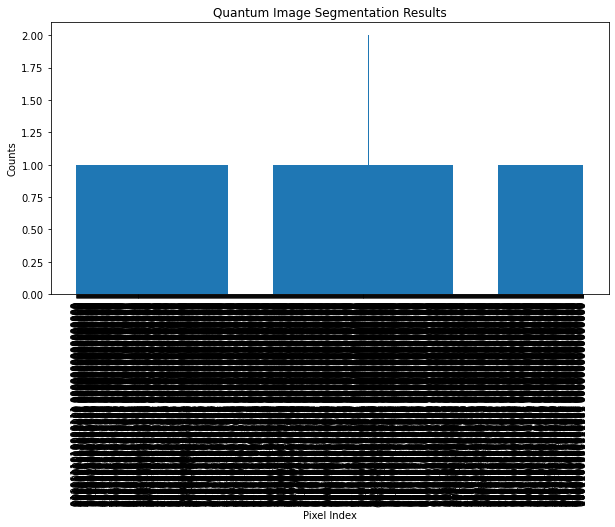

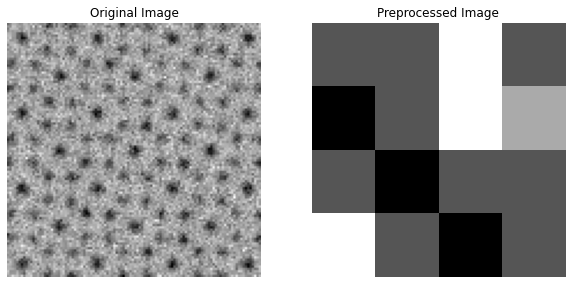

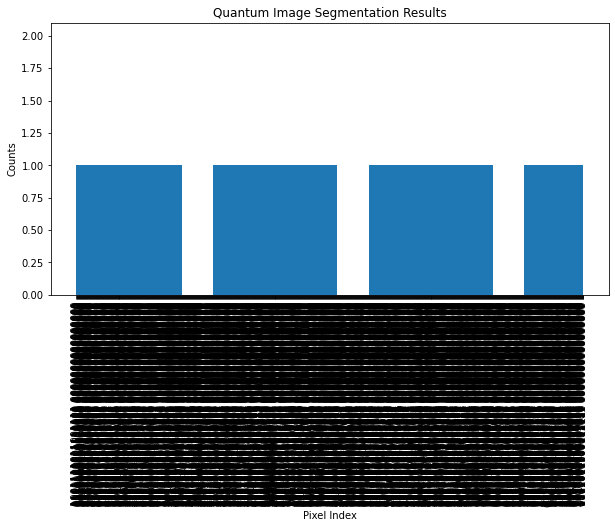

AttributeError: 'NoneType' object has no attribute 'size'

In [23]:
# Attempting for 1e3
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

def preprocess_image(image_path, size=(4, 4)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = size * size  # We need one qubit per pixel
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

def create_oracle(img_array, threshold=0.5):
    size = img_array.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    
    # Apply X gates for pixels below the threshold
    for i, pixel in enumerate(img_array.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))

def interpret_results(counts, size):
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image

def main(image_path):
    # Load and display the original image
    original_img = Image.open(image_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Preprocess the image
    img_array = preprocess_image(image_path)

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()

    # Encode the image into a quantum circuit
    qc_image = encode_image(img_array)

    # Create the oracle for the given image
    oracle = create_oracle(img_array)

    # Apply Grover's search
    apply_grovers_search(qc_image, oracle)

    # Measure the results
    qc_image.measure_all()

    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc_image, simulator)
    qobj = assemble(compiled_circuit)
    result = simulator.run(qobj).result()
    counts = result.get_counts()

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title("Quantum Image Segmentation Results")
    plt.xlabel("Pixel Index")
    plt.ylabel("Counts")
    plt.xticks(rotation=90)
    plt.show()
    return noisy_img

    # Interpret the results
def interpret_results(counts, size):
    print("Counts:", counts)  # Debug: Print counts to see their format
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(' ', '')  # Remove any spaces in the bitstring
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image


# Run the main function with the path to your image
main('Images/IrMnO2/resized_bf_image_Ir3pc_1e3dpa.png')  # Replace with your image path

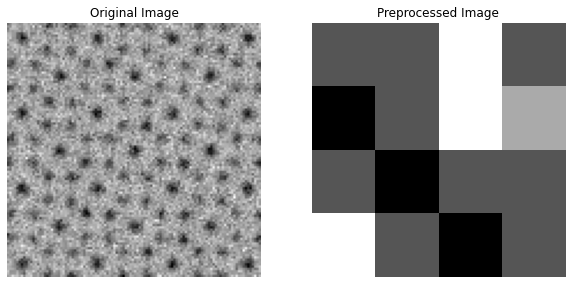

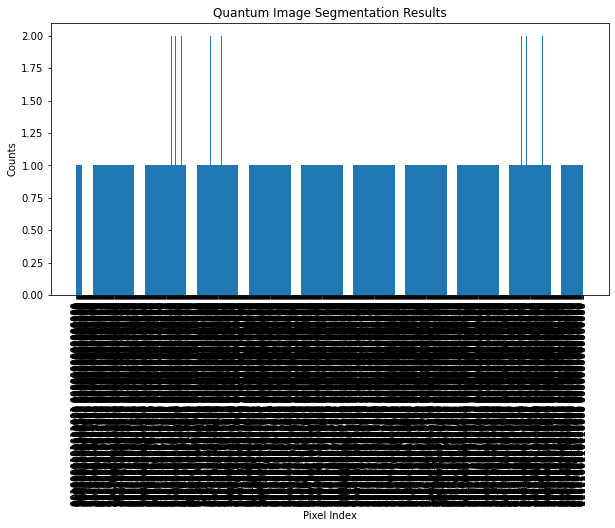

AttributeError: 'NoneType' object has no attribute 'size'

In [22]:
# 4. Apply QFT-based quantum denoising

from qiskit.circuit.library import QFT

def quantum_denoising_qft(qc, n_qubits):
    # Apply QFT
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    # (Optionally) add phase gates for frequency filtering here
    # Apply inverse QFT
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return qc

noisy_img = main('Images/IrMnO2/resized_bf_image_Ir3pc_1e3dpa.png')
n_qubits = noisy_img.size
qc_img_denoised = qc_img.copy()
qc_img_denoised = quantum_denoising_qft(qc_img_denoised, n_qubits)
qc_img_denoised.measure(range(n_qubits), range(n_qubits))
qc_img_denoised.draw('mpl')

def reconstruct_image_from_counts(counts, size):
    # Use the most frequent bitstring as the output image
    max_bitstring = max(counts, key=counts.get)
    pixels = np.array([int(bit) for bit in reversed(max_bitstring)])  # Qiskit uses little-endian
    img = pixels.reshape((size, size))
    return img

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc_img_denoised, backend=simulator, shots=2048).result()
counts = result.get_counts()

denoised_img = reconstruct_image_from_counts(counts, img_array.shape[0])

plt.imshow(denoised_img, cmap='gray', vmin=0, vmax=1)
plt.title("Quantum Denoised (QFT)")
plt.axis('off')
plt.show()

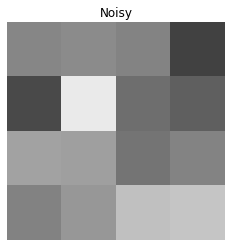

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path, size=(4,4)):
    img = Image.open(image_path).convert('L')
    img_resized = img.resize(size)
    img_array = np.array(img_resized) / 255.0
    return img_array

img_array = preprocess_image('Images/IrMnO2/resized_bf_image_Ir3pc_1e3dpa.png')
noisy_img = np.clip(img_array + np.random.normal(0, 0.2, img_array.shape), 0, 1)

plt.imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
plt.title("Noisy")
plt.axis('off')
plt.show()

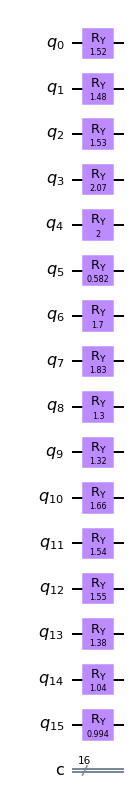

In [27]:
from qiskit import QuantumCircuit

def encode_image(img_array):
    n_qubits = img_array.size
    qc = QuantumCircuit(n_qubits, n_qubits)
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), i)
    return qc

qc_img = encode_image(noisy_img)
qc_img.draw('mpl')

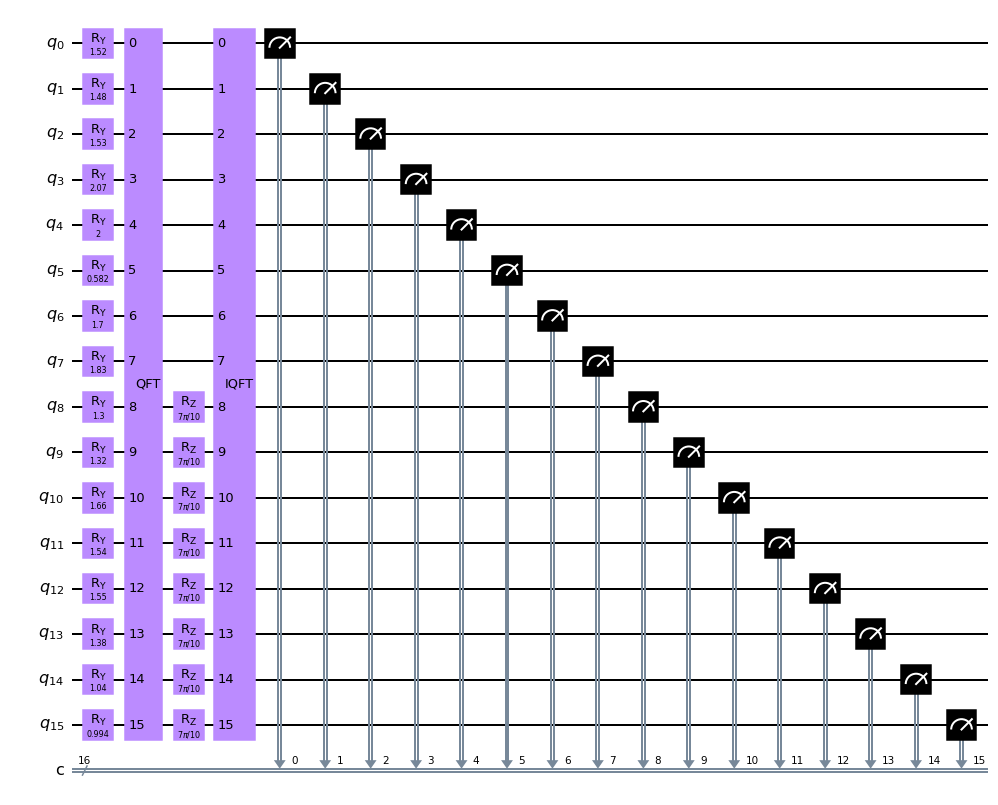

In [28]:
from qiskit.circuit.library import QFT

def quantum_lowpass_denoise(qc, n_qubits, filter_strength=0.7):
    # Apply QFT
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    # Apply phase damping to higher-frequency qubits (simulate frequency filter)
    # For 4x4: qubit 0 is lowest freq, qubit n_qubits-1 is highest
    # Dampen the two most significant qubits
    for q in range(n_qubits//2, n_qubits):
        qc.rz(np.pi * filter_strength, q)
    # Apply inverse QFT
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return qc

n_qubits = noisy_img.size
qc_img_denoised = encode_image(noisy_img)
qc_img_denoised = quantum_lowpass_denoise(qc_img_denoised, n_qubits)
qc_img_denoised.measure(range(n_qubits), range(n_qubits))
qc_img_denoised.draw('mpl')

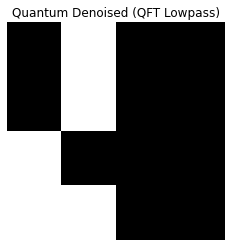

In [29]:
from qiskit import Aer, execute

def reconstruct_image_from_counts(counts, size):
    # Use the most frequent bitstring as the output image
    max_bitstring = max(counts, key=counts.get)
    pixels = np.array([int(bit) for bit in reversed(max_bitstring)])
    img = pixels.reshape((size, size))
    return img

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc_img_denoised, backend=simulator, shots=2048).result()
counts = result.get_counts()

denoised_img = reconstruct_image_from_counts(counts, img_array.shape[0])
plt.imshow(denoised_img, cmap='gray', vmin=0, vmax=1)
plt.title("Quantum Denoised (QFT Lowpass)")
plt.axis('off')
plt.show()

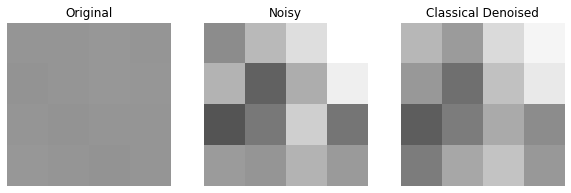

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image_path, size=(4, 4)):
    img = Image.open(image_path).convert('L')
    img_resized = img.resize(size)
    img_array = np.array(img_resized) / 255.0
    return img_array

img_array = preprocess_image('Images/IrMnO2/resized_bf_image_Ir3pc_1e3dpa.png', size=(4,4))
noisy_img = np.clip(img_array + np.random.normal(0, 0.2, img_array.shape), 0, 1)

# Classical FT denoising: zero out high frequencies
f = np.fft.fft2(noisy_img)
fshift = np.fft.fftshift(f)
rows, cols = noisy_img.shape
crow, ccol = rows//2 , cols//2
mask = np.zeros_like(noisy_img)
mask[crow-1:crow+2, ccol-1:ccol+2] = 1  # keep low frequencies
fshift_filtered = fshift * mask
f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.real(np.fft.ifft2(f_ishift))

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(img_array, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
plt.title('Noisy')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img_back, cmap='gray', vmin=0, vmax=1)
plt.title('Classical Denoised')
plt.axis('off')
plt.show()

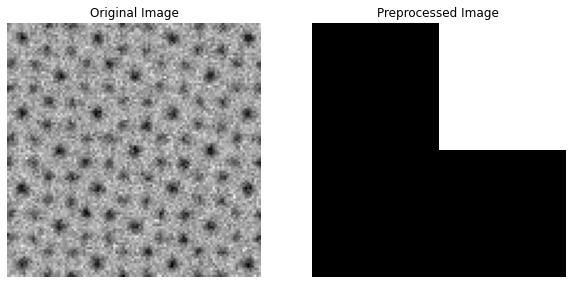

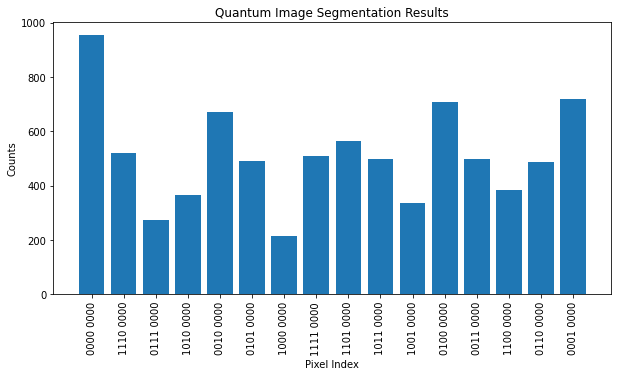

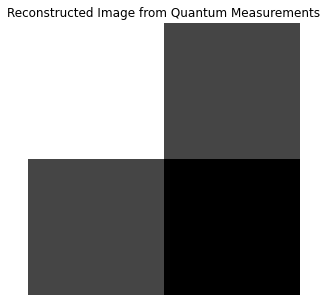

array([[0.52915137, 0.19827654],
       [0.19827654, 0.07429554]])

In [7]:
# Attempting for 1e3
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer
# from qiskit import execute
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

def preprocess_image(image_path, size=(2, 2)):
    # Load the image
    img = Image.open(image_path).convert('L')
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img_resized) / 255.0
    
    return img_array

def encode_image(img_array):
    size = img_array.shape[0]
    n_qubits = size * size  # We need one qubit per pixel
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Flatten the image array and encode each pixel value into a quantum state
    flat_img = img_array.flatten()
    for i, pixel in enumerate(flat_img):
        if pixel > 0:
            qc.ry(2 * np.arccos(np.sqrt(pixel)), qr[i])
    
    return qc

def create_oracle(img_array, threshold=0.5):
    size = img_array.shape[0]
    n_qubits = size * size
    oracle_qc = QuantumCircuit(n_qubits)
    
    # Apply X gates for pixels below the threshold
    for i, pixel in enumerate(img_array.flatten()):
        if pixel < threshold:
            oracle_qc.x(i)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    oracle_qc.append(mcx, list(range(n_qubits)))
    
    return oracle_qc.to_gate(label='Oracle')

def diffusion_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply multi-controlled-X gate
    mcx = MCXGate(n_qubits - 1)
    qc.append(mcx, list(range(n_qubits)))
    
    # Apply X gates
    for qubit in range(n_qubits):
        qc.x(qubit)
    
    # Apply Hadamard gates
    for qubit in range(n_qubits):
        qc.h(qubit)
    
    return qc.to_gate(label='Diffusion')

def apply_grovers_search(qc, oracle, n_iterations=1):
    n_qubits = qc.num_qubits
    diffusion = diffusion_operator(n_qubits)
    
    for _ in range(n_iterations):
        qc.append(oracle, list(range(n_qubits)))
        qc.append(diffusion, list(range(n_qubits)))

def interpret_results(counts, size):
    segmented_image = np.zeros((size, size))
    for bitstring, count in counts.items():
        index = int(bitstring, 2)
        if count > 0:
            row = index // size
            col = index % size
            segmented_image[row, col] = 1
    return segmented_image

def main(image_path):
    # Load and display the original image
    original_img = Image.open(image_path)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Preprocess the image
    img_array = preprocess_image(image_path)

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()

    # Encode the image into a quantum circuit
    qc_image = encode_image(img_array)

    # Create the oracle for the given image
    oracle = create_oracle(img_array)

    # Apply Grover's search
    apply_grovers_search(qc_image, oracle)

    # Measure the results
    qc_image.measure_all()

    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc_image, simulator)
    qobj = assemble(compiled_circuit)
    result = simulator.run(qobj, shots=8192).result()
    counts = result.get_counts()

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title("Quantum Image Segmentation Results")
    plt.xlabel("Pixel Index")
    plt.ylabel("Counts")
    plt.xticks(rotation=90)
    plt.show()
    
    size = img_array.shape[0]
    reconstructed_img = interpret_results(counts, size)

    # Show reconstructed/denoised image
    plt.figure(figsize=(5, 5))
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title("Reconstructed Image from Quantum Measurements")
    plt.axis('off')
    plt.show()

    return reconstructed_img

    # Interpret the results
def interpret_results(counts, size):
    flat_size = size * size
    pixel_values = np.zeros(flat_size)
    total_counts = sum(counts.values())

    if total_counts == 0:
        print("Warning: No counts measured.")
        return np.zeros((size, size))  # black image fallback

    for bitstring, count in counts.items():
        # Pad to match length (in case Qiskit drops leading 0s)
        bitstring = bitstring.replace(' ', '').zfill(int(np.log2(flat_size)))
        index = int(bitstring, 2)
        if index < flat_size:
            pixel_values[index] = count

    # Normalize to 0–1
    pixel_values /= pixel_values.max() if pixel_values.max() > 0 else 1
    pixel_image = pixel_values.reshape((size, size))

    # Optional smoothing for denoising
    from scipy.ndimage import gaussian_filter
    denoised_image = gaussian_filter(pixel_image, sigma=0.8)

    return denoised_image




# Run the main function with the path to your image
main('Images/IrMnO2/resized_bf_image_Ir3pc_1e3dpa.png')  # Replace with your image path